# Solve the lens equation in a JAX-friendly way

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
plt.rc('image', interpolation='none')

# Basic imports
import numpy as np

# JAX-related imports
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.MassModel.mass_model import MassModel
from herculens.LightModel.light_model import LightModel
from herculens.LensImage.lens_image import LensImage
from herculens.PointSourceModel.point_source_model import PointSourceModel
from herculens.MassModel.lens_equation import LensEquationSolver as LES

import ipywidgets

# from scipy.optimize import shgo

## Pixel grid

In [2]:
npix = 100  # number of pixels per side
pix_size = 5. / npix  # angular pixel size [arcsec]
plane_half_size = npix * pix_size / 2.  # half image angular extent per side [arcsec]
ra_at_xy_0 = dec_at_xy_0 = -plane_half_size + pix_size / 2  # angular coordinates of the pixel (0, 0)
transform_pix2angle = pix_size * np.eye(2)  # transformation matrix between pixel and angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_size} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.05 arcsec
x range    : (-2.475, 2.475) arcsec
y range    : (-2.475, 2.475) arcsec


## Mass model

In [3]:
mass_model = MassModel(['SIE', 'SHEAR'])
kwargs_sie = {'theta_E': 1.4, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}
# kwargs_shear = {'gamma1': 0.02, 'gamma2': -0.08}
kwargs_shear = {'gamma1': 0.0, 'gamma2': 0.0}
kwargs_lens = [kwargs_sie, kwargs_shear]

## Source light model

In [4]:
source_light_model_list = ['SERSIC']
source_model = LightModel(source_light_model_list)
beta_x, beta_y = -0.12, 0.0 # 0.035, -0.05
kwargs_source = [{'amp': 4, 'R_sersic': 0.5, 'n_sersic': 2, 'center_x': beta_x, 'center_y': beta_y}]

beta_true = jnp.array([beta_x, beta_y])

# source_model = LightModel(['PIXELATED'])
# pixels = np.zeros((npix, npix))
# beta_x, beta_y = 0.075, -0.05
# i, j = pixel_grid.map_coord2pix(beta_x, beta_y)
# pixels[int(j), int(i)] = 1.
# kwargs_source = [{'pixels': pixels}]

## PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1}
# kwargs_psf = {'psf_type': 'NONE'}
psf = PSF(**kwargs_psf)

## Image model

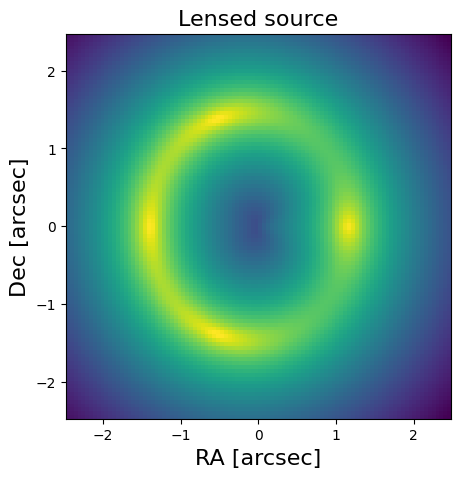

In [6]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 5}
lens_image = LensImage(pixel_grid, psf,
                       lens_mass_model_class=mass_model,
                       source_model_class=source_model,
                       kwargs_numerics=kwargs_numerics)

kwargs_all = dict(kwargs_lens=kwargs_lens,
                  kwargs_source=kwargs_source,
                  kwargs_lens_light={})
image = lens_image.model(**kwargs_all)
log_image = np.log(image)

# visualize simulated products
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(log_image, origin='lower', extent=pixel_grid.extent)
ax.set_aspect('equal')
ax.set_title('Lensed source', fontsize=16)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);
# plt.savefig('/Users/austinpeel/Desktop/lensed_pt_src.png', format='png')

### Triangulate the image plane

In [38]:
# class Triangle(object):
#     def __init__(self, vertices):
#         """A triangle defined by 3 vertices.
        
#         Parameters
#         ----------
#         vertices : array of shape (3, 2)
#             Vertex positions arranged as [[x1, y1], [x2, y2], [x3, y3]]
        
#         """
#         vertices = jnp.atleast_2d(vertices)
#         if vertices.shape != (3, 2):
#             print("Input array must have shape (3, 2)")
#             return
        
#         self.vertices = vertices
#         self.v1, self.v2, self.v3 = jnp.atleast_2d(self.vertices)
    
#     def contains_point(self, point):
#         """Determine whether a point lies within the triangle.
        
#         Points lying along the triangle's edges are not considered
#         to be within the triangle.
        
#         Parameters
#         ----------
#         point : array of shape (2,)
#             Point to test.
            
#         Returns
#         -------
#         bool : result
#             Whether the triangle contains the input point.
        
#         """
#         p = jnp.atleast_1d(point)
#         delta1 = self.v1 - p
#         delta2 = self.v2 - p
#         delta3 = self.v3 - p
#         sign1 = jnp.sign(jnp.cross(delta1, delta2))
#         sign2 = jnp.sign(jnp.cross(delta2, delta3))
#         sign3 = jnp.sign(jnp.cross(delta3, delta1))
#         return abs(sign1 + sign2 + sign3) == 3
    
#     def subdivide(self):
#         """Divide the triangle into 4 congruent triangles."""
#         v4 = 0.5 * (self.v1 + self.v2)
#         v5 = 0.5 * (self.v2 + self.v3)
#         v6 = 0.5 * (self.v3 + self.v1)
#         triangles = []
#         triangles.append(Triangle([self.v1, v4, v6]))
#         triangles.append(Triangle([v4, self.v2, v5]))
#         triangles.append(Triangle([v6, v4, v5]))
#         triangles.append(Triangle([v6, v5, self.v3]))
#         return triangles
    
#     def scale(self, scale_factor):
#         """Scale the triangle about its centroid.
        
#         scale_factor : float
#             Factor by which the triangle's area is scaled.
        
#         """
#         c = self.centroid
#         factor = jnp.sqrt(scale_factor)
#         self.v1 = c + factor * (self.v1 - c)
#         self.v2 = c + factor * (self.v2 - c)
#         self.v3 = c + factor * (self.v3 - c)
#         self.vertices = jnp.array([self.v1, self.v2, self.v3])
        
#     @property
#     def signed_area(self):
#         """The signed area of the triangle."""
#         return 0.5 * jnp.cross(self.v2 - self.v1, self.v3 - self.v2)
    
#     @property
#     def area(self):
#         """The unsigned area of the triangle."""
#         return abs(self.signed_area)
    
#     @property
#     def xy(self):
#         """The x and y coordinates of the vertices."""
#         return jnp.vstack([self.v1, self.v2, self.v3]).T
    
#     @property
#     def centroid(self):
#         """The centroid position of the triangle."""
#         return (self.v1 + self.v2 + self.v3) / 3.
    
    
# class LensEquationSolver(object):
#     def __init__(self, pixel_grid, beta, mass_model):
#         """Solver for the multiple lensed image positions of a source point.
        
#         Parameters
#         ----------
#         pixel_grid : `herculens.Coordinates.pixel_grid.PixelGrid`
#             Instance of PixelGrid defining the initial ray-shooting positions.
#             This should in general be at lower resolution than the data.
#         beta : array of shape (2,)
#             Position in the source plane.
#         mass_model : `herculens.MassModel.mass_model.MassModel`
#             Instance of MassModel defining the lens potential and deflection 
#             angles.
        
#         """
#         self.pixel_grid = pixel_grid
#         self.beta = beta
#         self.mass_model = mass_model
        
#         self.shoot_rays = jax.jit(self._shoot_rays)
    
#     def _shoot_rays(self, x, y, kwargs_lens):
#         return self.mass_model.ray_shooting(x, y, kwargs_lens)
    
#     def pixel2triangles(self, i, j):
#         """Two triangles corresponding to a pixel position.
        
#         Parameters
#         ----------
#         i, j : int
#             Indices of the pixel to triangulate.
        
#         Returns
#         -------
#         Tuple of jax arrays containing the vertex arrays [shape (3, 2)] of the
#         two triangles.
#         """
#         x, y = self.pixel_grid.map_pix2coord(i, j)
#         delta = 0.5 * self.pixel_grid.pixel_width
#         vertices1 = [[x - delta, y - delta], [x + delta, y - delta], [x - delta, y + delta]]
#         vertices2 = [[x + delta, y - delta], [x + delta, y + delta], [x - delta, y + delta]]
#         triangle1 = Triangle(vertices1)
#         triangle2 = Triangle(vertices2)
        
#         return triangle1, triangle2
        
#     def image_plane_triangles(self):
#         """Image plane triangles based on the original pixel grid."""
#         triangles = [0] * (2 * self.pixel_grid.num_pixel)
#         nx, ny = self.pixel_grid.num_pixel_axes
#         for k in range(self.pixel_grid.num_pixel):
#             i = k % nx
#             j = (k - i) // ny
#             t1, t2 = self.pixel2triangles(i, j)
#             triangles[2 * k] = t1
#             triangles[2 * k + 1] = t2
        
#         return np.array(triangles)
    
#     def source_plane_triangles(self, image_triangles, kwargs_lens):
#         """Source plane triangles corresponding to image plane counterparts.
        
#         Parameters
#         ----------
#         image_triangles : list of `Triangle`
#             A set of triangles defined in the image plane.
#         kwargs_lens : dict
#             Parameters defining the mass model.
            
#         """        
#         triangles = [0] * len(image_triangles)
#         for k in range(len(triangles)):
#             triangle = image_triangles[k]
#             theta1, theta2 = triangle.xy
#             beta1, beta2 = self.shoot_rays(theta1, theta2, kwargs_lens)
#             triangles[k] = Triangle(jnp.vstack([beta1, beta2]).T)
            
#         return np.array(triangles)
    
#     def solve(self, kwargs_lens, niter=5, scale_factor=2):
#         """Solve the lens equation.
        
#         Parameters
#         ----------
#         kwargs_lens : dict
#             Parameters defining the mass model.
#         niter : int
#             ...
#         scale_factor : float
#             ....
            
#         """
#         img_triangles = self.image_plane_triangles()
#         src_triangles = self.source_plane_triangles(img_triangles, kwargs_lens)
        
#         inds = self.indices_containing_point(src_triangles)
#         img_selection = img_triangles[inds]
                    
#         for i in range(niter):
#             for t in img_selection:
#                 t.scale(scale_factor)
#             img_selection = [item for sublist in [t.subdivide() for t in img_selection] for item in sublist]
#             src_selection = self.source_plane_triangles(img_selection, kwargs_lens)
#             inds = self.indices_containing_point(src_selection)
#             img_selection = [img_selection[k] for k in inds]
# #             if i == niter - 1:
# #                 for k in inds:
# #                     print(img_selection[k].centroid, src_selection[k].centroid)
# #             else:
# #                 img_selection = [img_selection[k] for k in inds]
#         src_selection = [src_selection[k] for k in inds]

#         return jnp.array([t.centroid for t in img_selection]), jnp.array([t.centroid for t in src_selection])
    
#     def num_multiple_images(self, triangles):
#         return np.sum([t.contains_point(self.beta) for t in triangles])

#     def indices_containing_point(self, triangles):
#         return [k for k in range(len(triangles)) if triangles[k].contains_point(self.beta)]
    
    
class LensEquationSolver(object):
    def __init__(self, mass_model):
        """Solver for the multiple lensed image positions of a source point.

        Parameters
        ----------
        mass_model : `herculens.MassModel.mass_model.MassModel`
            Instance of MassModel defining the lens potential and deflection
            angles.

        """
        self.mass_model = mass_model

        self.shoot_rays = jax.jit(self._shoot_rays)
        # self.shoot_rays = self._shoot_rays

    def _shoot_rays(self, x, y, kwargs_lens):
        return self.mass_model.ray_shooting(x, y, kwargs_lens)

    def triangulate(self, pixel_grid):
        """Triangulate a pixel grid.

        Parameters
        ----------
        pixel_grid : `herculens.Coordinates.pixel_grid.PixelGrid`
            Instance of PixelGrid defining the initial ray-shooting positions.
            This can in general be at lower resolution than the data.
            
        Returns
        -------
        out : jax array of shape (2 * N, 3, 2)
            Vertices of 2 * N triangles, where each pixel is divided in half 
            along the diagonal.
            
        """
        xgrid, ygrid = pixel_grid.pixel_coordinates
        xcoords, ycoords = xgrid.flatten(), ygrid.flatten()
        delta = 0.5 * pixel_grid.pixel_width

        # Coordinates of the four corners of each pixel
        x_LL, y_LL = xcoords - delta, ycoords - delta
        x_LR, y_LR = xcoords + delta, ycoords - delta
        x_UL, y_UL = xcoords - delta, ycoords + delta
        x_UR, y_UR = xcoords + delta, ycoords + delta
        a = jnp.array([[x_LL, y_LL], [x_LR, y_LR], [x_UL, y_UL]]).transpose(2, 0, 1)
        b = jnp.array([[x_LR, y_LR], [x_UR, y_UR], [x_UL, y_UL]]).transpose(2, 0, 1)

        # Interleave arrays so that the two triangles corresponding to a pixel are adjacent 
        triangles = jnp.column_stack((a, b))

        return triangles.reshape(2 * pixel_grid.num_pixel, 3, 2)

    def source_plane_triangles(self, image_triangles, kwargs_lens):
        """Source plane triangles corresponding to image plane counterparts.

        Parameters
        ----------
        image_triangles : jax array of shape (N, 3, 2)
            Vertices defining N triangles in the image plane.
        kwargs_lens : dict
            Parameters defining the mass model.

        """
        # Unpack into (x, y) triangle vertex arrays
        n = len(image_triangles)
        theta1, theta2 = image_triangles.transpose((2, 0, 1)).reshape((2, 3 * n))

        # Shoot vertices to the source plane
        beta1, beta2 = self.shoot_rays(theta1, theta2, kwargs_lens)

        # Repack into an array of triangle vertices
        return jnp.vstack([beta1, beta2]).reshape((2, n, 3)).transpose((1, 2, 0))

    def indices_containing_point(self, triangles, point):
        """Determine whether a point lies within a triangle.

        Points lying along a triangle's edges are not considered
        to be within in it.

        Parameters
        ----------
        triangles : jax array of shape (N, 3, 2)
            Vertices defining N triangles.
        point : jax array of shape (2,)
            Point to test.

        Returns
        -------
        bool : jax array of shape (N,)
            Whether each triangle contains the input point.

        """
        # Distances between each vertex and the input point
        delta = triangles - jnp.atleast_1d(point)

        sign1 = jnp.sign(jnp.cross(delta[:, 0], delta[:, 1]))
        sign2 = jnp.sign(jnp.cross(delta[:, 1], delta[:, 2]))
        sign3 = jnp.sign(jnp.cross(delta[:, 2], delta[:, 0]))
        return jnp.abs(sign1 + sign2 + sign3) == 3

    def scale_triangles(self, triangles, scale_factor):
        """Scale triangles about their centroids.

        scale_factor : float
            Factor by which each triangle's area is scaled.

        """
        c = self.centroids(triangles)
        c = jnp.repeat(jnp.expand_dims(c, 1), repeats=3, axis=1)
        return c + scale_factor**0.5 * (triangles - c)

    def subdivide_triangles(self, triangles, niter=1):
        """Divide a set of triangles into 4 congruent triangles.

        Parameters
        ----------
        triangles : TODO
            ...
        niter : int
            ...
            
        """
#         subtriangles = jnp.zeros((4 * len(triangles), 3, 2))
#         for k in range(len(triangles)):
#             triangle = triangles[k]
#             v1 = triangle[0]
#             v2 = triangle[1]
#             v3 = triangle[2]
#             v4 = 0.5 * (v1 + v2)
#             v5 = 0.5 * (v2 + v3)
#             v6 = 0.5 * (v3 + v1)
#             t1 = jnp.array([v1, v4, v6])
#             t2 = jnp.array([v4, v2, v5])
#             t3 = jnp.array([v6, v4, v5])
#             t4 = jnp.array([v6, v5, v3])
#             subtriangles = subtriangles.at[4 * k].set(t1)
#             subtriangles = subtriangles.at[4 * k + 1].set(t2)
#             subtriangles = subtriangles.at[4 * k + 2].set(t3)
#             subtriangles = subtriangles.at[4 * k + 3].set(t4)
#         return subtriangles

        # NOTE : triangles are not in the same order as above
        v1, v2, v3 = triangles.transpose(1, 0, 2)
        v4 = 0.5 * (v1 + v2)
        v5 = 0.5 * (v2 + v3)
        v6 = 0.5 * (v3 + v1)
        t1 = [v1, v4, v6]
        t2 = [v4, v2, v5]
        t3 = [v6, v4, v5]
        t4 = [v6, v5, v3]
        subtriangles = jnp.column_stack((t1, t2, t3, t4)).transpose(1, 0, 2)
        
        for k in range(1, niter):
            v1, v2, v3 = subtriangles.transpose(1, 0, 2)
            v4 = 0.5 * (v1 + v2)
            v5 = 0.5 * (v2 + v3)
            v6 = 0.5 * (v3 + v1)
            t1 = [v1, v4, v6]
            t2 = [v4, v2, v5]
            t3 = [v6, v4, v5]
            t4 = [v6, v5, v3]
            subtriangles = jnp.column_stack((t1, t2, t3, t4)).transpose(1, 0, 2)
    
        return subtriangles.reshape(4**niter * len(triangles), 3, 2)

    def centroids(self, triangles):
        """The centroid positions of triangles."""
        return triangles.sum(axis=1) / 3.

    def signed_areas(self, triangles):
        """The signed area of triangles."""
        side1 = triangles[:, 1] - triangles[:, 0]
        side2 = triangles[:, 2] - triangles[:, 1]
        return 0.5 * jnp.cross(side1, side2)

    def solve(self, image_plane, beta, kwargs_lens, niter=5, scale_factor=2, nsubdivisions=1):
        """Solve the lens equation.

        Parameters
        ----------
        image_plane : `herculens.Coordinates.pixel_grid.PixelGrid`
            Instance of PixelGrid defining the initial ray-shooting positions.
            This can in general be at lower resolution than the data.
        beta : jax array of shape (2,)
            Position of a point source in the source plane.
        kwargs_lens : dict
            Parameters defining the mass model.
        niter : int
            ...
        scale_factor : float
            ...
        nsubdivisions : int
            ...

        """
        # Triangulate the image plane
        img_triangles = self.triangulate(image_plane)

        # Compute source plane images of the image plane triangles
        src_triangles = self.source_plane_triangles(img_triangles, kwargs_lens)

        # Retain only those image plane triangles whose source image contains the point source
        inds = self.indices_containing_point(src_triangles, beta)
        img_selection = img_triangles[jnp.where(inds, size=5)]

        for k in range(niter):
            # Scale up triangles
            img_selection = self.scale_triangles(img_selection, scale_factor)

            # Subdivide each triangle into 4
            img_selection = self.subdivide_triangles(img_selection, nsubdivisions)

            # Ray-shoot subtriangles to the source plane
            src_selection = self.source_plane_triangles(img_selection, kwargs_lens)

            # Select corresponding image plane triangles containing the source point
            inds = self.indices_containing_point(src_selection, beta)
            img_selection = img_selection[jnp.where(inds, size=5)]

        # Ray-shoot the final image plane triangles to the source plane
        src_selection = self.source_plane_triangles(img_selection, kwargs_lens)

        return self.centroids(img_selection), self.centroids(src_selection)

## Image plane for tiling (low-res)

In [39]:
npix_image = 49
image_pix_size = 5. / npix_image
image_plane_half_size = npix_image * image_pix_size / 2.
image_ra_at_xy_0 = image_dec_at_xy_0 = -image_plane_half_size + image_pix_size / 2
image_transform_pix2angle = image_pix_size * np.eye(2)
kwargs_image_plane = {'nx': npix_image, 'ny': npix_image,
                     'ra_at_xy_0': image_ra_at_xy_0, 'dec_at_xy_0': image_dec_at_xy_0,
                     'transform_pix2angle': image_transform_pix2angle}
image_plane = PixelGrid(**kwargs_image_plane)

solver = LensEquationSolver(mass_model)
solver.shoot_rays(0.0, 0.0, kwargs_lens)

(DeviceArray(0., dtype=float64, weak_type=True),
 DeviceArray(0., dtype=float64, weak_type=True))

In [40]:
theta, beta = solver.solve(image_plane, beta_true, kwargs_lens, niter=2, scale_factor=2, nsubdivisions=5)
theta, beta

(DeviceArray([[-1.40998597e+00, -4.49467785e-04],
              [ 1.16992747e+00,  1.90108705e-04],
              [-5.27666890e-01,  1.40129221e+00],
              [ 1.55619767e-05,  1.55619767e-05],
              [-5.27031167e-01, -1.40149821e+00]], dtype=float64),
 DeviceArray([[-1.20103666e-01, -9.06943770e-06],
              [-1.19954895e-01,  1.76704330e-05],
              [-1.19983957e-01, -4.97615799e-05],
              [-1.73337673e-01, -2.59464354e-01],
              [-1.19988877e-01,  2.48336436e-05]], dtype=float64))

In [10]:
theta.shape

(5, 2)

In [10]:
def solver_func(beta_true, kwargs_lens, scale_factor):
#     return solver.solve(image_plane, beta_true, kwargs_lens, niter=2, scale_factor=scale_factor, nsubdivisions=5)
    return solver.solve(image_plane, beta_true, kwargs_lens, niter=1, scale_factor=scale_factor, nsubdivisions=5)


jit_solve = jax.jit(solver_func)

In [11]:
jit_solve(beta_true, kwargs_lens, 2.0)

(DeviceArray([[-5.27770952e-01, -1.40104220e+00],
              [-5.28714088e-01,  1.40104220e+00],
              [ 1.17102305e+00, -1.03163557e-03],
              [ 4.71567617e-04,  4.71567617e-04],
              [-1.41006142e+00,  4.71567617e-04]], dtype=float64),
 DeviceArray([[-1.20096404e-01,  2.41180598e-04],
              [-1.20241411e-01, -1.20549744e-06],
              [-1.18855852e-01,  5.82278375e-04],
              [-2.05221850e-01, -2.91911880e-01],
              [-1.20181078e-01, -2.06105649e-04]], dtype=float64))

In [12]:
## Critical curve and caustic approximation

npix_hires = 300  # number of pixels per side
pix_size_hires = 5. / npix_hires  # angular pixel size [arcsec]
plane_half_size_hires = npix_hires * pix_size_hires / 2.  # half image angular extent per side [arcsec]
ra_at_xy_0_hires = dec_at_xy_0_hires = -plane_half_size_hires + pix_size_hires / 2
transform_pix2angle_hires = pix_size_hires * np.eye(2)  # transformation matrix between pixel and angle
kwargs_pixel_hires = {'nx': npix_hires, 'ny': npix_hires,
                'ra_at_xy_0': ra_at_xy_0_hires, 'dec_at_xy_0': dec_at_xy_0_hires,
                'transform_pix2angle': transform_pix2angle_hires}

# create the hi-res PixelGrid class
pixel_grid_hires = PixelGrid(**kwargs_pixel_hires)
xgrid_hires, ygrid_hires = pixel_grid_hires.pixel_coordinates

mag = mass_model.magnification(xgrid_hires, ygrid_hires, kwargs_lens)
grad_mag = np.gradient((mag > 0).astype(float))
crit_curve_inds = np.sum(np.abs(grad_mag), axis=0) > 0

crit_curve_x = xgrid_hires[crit_curve_inds]
crit_curve_y = ygrid_hires[crit_curve_inds]
caustic_x, caustic_y = mass_model.ray_shooting(crit_curve_x, crit_curve_y, kwargs_lens)

# fig, ax = plt.subplots(1, 1)
# mappable = ax.imshow(crit_curve_inds.astype(float))
# plt.colorbar(mappable)

In [13]:
@ipywidgets.interact(beta_x=(-1.0, 1.0, 0.01), beta_y=(-1.0, 1.0, 0.01), scale_factor=(1.0, 5.0, 0.1))
def source_plane(beta_x=beta_true[0], beta_y=beta_true[1], scale_factor=2.0):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))

    ax = axes[0]
    x_grid, y_grid, = pixel_grid.pixel_coordinates
    ax.axhline(0, -2, 2, ls='--', lw=1, c='k')
    ax.axvline(0, -2, 2, ls='--', lw=1, c='k')
    ax.scatter(caustic_x, caustic_y, c='k', s=0.01)
    ax.scatter(beta_x, beta_y, marker='*', c='r', s=80)
    ax.set_title('Source Plane', fontsize=18)
    
    ax = axes[1]
    ax.imshow(1 - crit_curve_inds.astype(float), alpha=1, extent=extent, cmap='gray', origin='lower')
    ax.axhline(0, -2, 2, ls='--', lw=1, c='k')
    ax.axvline(0, -2, 2, ls='--', lw=1, c='k')
    theta, beta = jit_solve(jnp.array([beta_x, beta_y]), kwargs_lens, scale_factor)
    theta_x, theta_y = theta.T
    ax.scatter(theta_x, theta_y, marker='*', fc='pink', ec='r', lw=0.4, s=80)
    ax.set_title('Image Plane', fontsize=18)
    
    for ax in axes:
        ax.set_xlim(-image_plane.width[0] / 2, image_plane.width[0] / 2)
        ax.set_ylim(-image_plane.width[1] / 2, image_plane.width[1] / 2)
        ax.set_aspect('equal')
        ax.set_xlabel('RA [arcsec]', fontsize=16)
        ax.set_ylabel('Dec [arcsec]', fontsize=16);

interactive(children=(FloatSlider(value=-0.12, description='beta_x', max=1.0, min=-1.0, step=0.01), FloatSlide…

## Illustrations

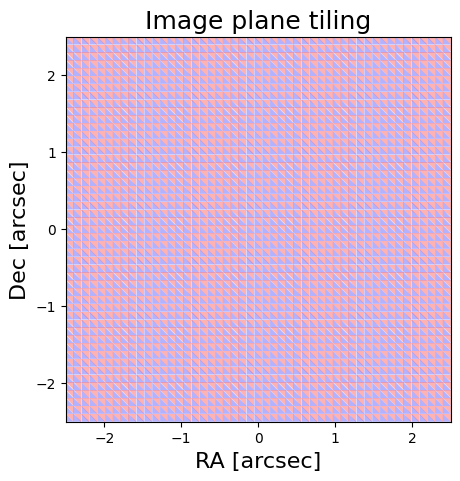

In [14]:
img_triangles = solver.triangulate(image_plane)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
patches = []
face_colors = []
for k in range(len(img_triangles)):
    triangle = img_triangles[k]
    face_colors.append('b' if k % 2 == 0 else 'r')
    patches.append(Polygon(triangle))
patch_collection = PatchCollection(patches, alpha=0.3, fc=face_colors)
ax.add_collection(patch_collection)

# x, y = image_plane.pixel_coordinates
# ax.scatter(x, y, marker='o', color='k', alpha=0.5, s=1)
    
ax.set_xlim(-image_plane.width[0] / 2, image_plane.width[0] / 2)
ax.set_ylim(-image_plane.width[1] / 2, image_plane.width[1] / 2)
ax.set_aspect('equal')
ax.set_title('Image plane tiling', fontsize=18)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);
# plt.savefig('/Users/austinpeel/Desktop/image_plane_tiling.png', format='png')

### Map image plane triangles to the source plane

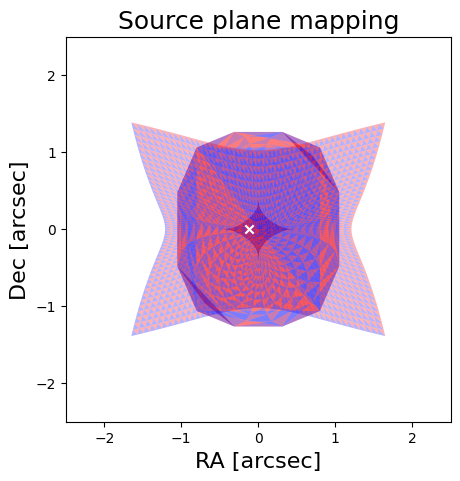

In [15]:
src_triangles = solver.source_plane_triangles(img_triangles, kwargs_lens)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

patches = []
face_colors = []
for k in range(len(src_triangles)):
    triangle = src_triangles[k]
    face_colors.append('b' if k % 2 == 0 else 'r')
    patches.append(Polygon(triangle))
patch_collection = PatchCollection(patches, alpha=0.3, fc=face_colors)
ax.add_collection(patch_collection)

ax.scatter(beta_x, beta_y, c='w', marker='x')

ax.set_xlim(-image_plane.width[0] / 2, image_plane.width[0] / 2)
ax.set_ylim(-image_plane.width[1] / 2, image_plane.width[1] / 2)
ax.set_aspect('equal')
ax.set_title('Source plane mapping', fontsize=18)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);
# plt.savefig('/Users/austinpeel/Desktop/src_plane_mapping.png', format='png')

In [311]:
inds = solver.indices_containing_point(src_triangles, beta_true)
jnp.where(inds)

(DeviceArray([1019, 2373, 2401, 2423, 3762], dtype=int64),)

## Select and iterate

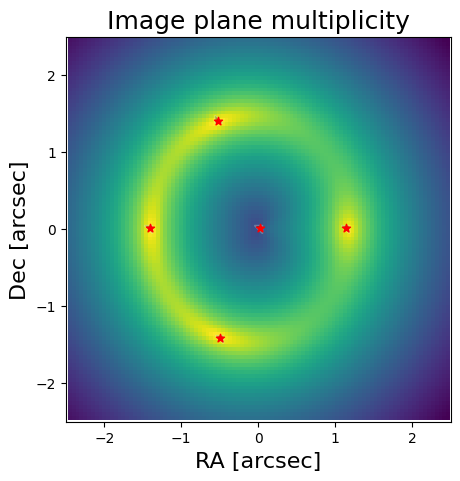

In [312]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

inds = solver.indices_containing_point(src_triangles, beta_true)
selected_triangles = img_triangles[inds]
selected_triangles = solver.scale_triangles(selected_triangles, 1)

centroids = solver.centroids(selected_triangles)

for k in range(len(selected_triangles)):
    xs, ys = selected_triangles[k].T
    xc, yc = centroids[k]
    ax.fill(xs, ys, alpha=0.3, fc='k', ec='w', zorder=1)
    ax.scatter(xc, yc, alpha=1, fc='r', marker='*')

ax.imshow(log_image, origin='lower', extent=pixel_grid.extent, alpha=1)

ax.set_xlim(-image_plane.width[0] / 2, image_plane.width[0] / 2)
ax.set_ylim(-image_plane.width[1] / 2, image_plane.width[1] / 2)
ax.set_aspect('equal')
ax.set_title('Image plane multiplicity', fontsize=18)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);
# plt.savefig('/Users/austinpeel/Desktop/image_plane_multiplicity.png', format='png')

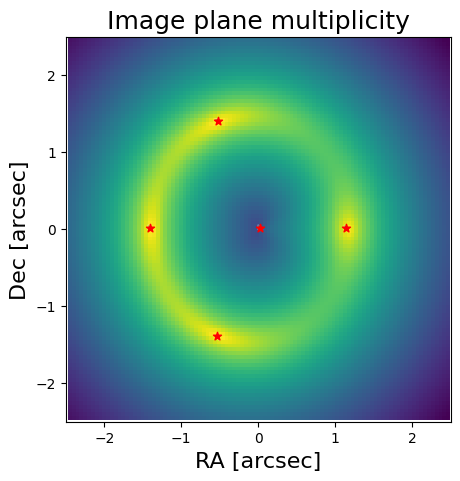

In [23]:
niter = 2
scale_factor = 1.5
beta_test = jnp.array([beta_x, beta_y])

# Triangulate the image plane
img_triangles = solver.triangulate(image_plane)
# img_triangles += 0.001

# Compute source plane images of the image plane triangles
src_triangles = solver.source_plane_triangles(img_triangles, kwargs_lens)

# Retain only those image plane triangles whose source image contains the point source
img_selection = img_triangles[solver.indices_containing_point(src_triangles, beta_test)]

for k in range(1, niter):
    # Scale up triangles
    img_selection = solver.scale_triangles(img_selection, scale_factor)

    # Subdivide each triangle into 4
    img_selection = solver.subdivide_triangles(img_selection)

    # Ray-shoot subtriangles to the source plane
    src_selection = solver.source_plane_triangles(img_selection, kwargs_lens)

    # Select corresponding image plane triangles containing the source point
    img_selection = img_selection[solver.indices_containing_point(src_selection, beta_test)]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

centroids = solver.centroids(img_selection)
for k in range(len(img_selection)):
    xs, ys = img_selection[k].T
    ax.fill(xs, ys, alpha=0.3, fc='k', ec='w', zorder=1)
    xc, yc = centroids[k]
    ax.scatter(xc, yc, alpha=1, fc='r', marker='*')

ax.imshow(log_image, origin='lower', extent=pixel_grid.extent, alpha=1)

ax.set_xlim(-image_plane.width[0] / 2, image_plane.width[0] / 2)
ax.set_ylim(-image_plane.width[1] / 2, image_plane.width[1] / 2)
ax.set_aspect('equal')
ax.set_title('Image plane multiplicity', fontsize=18)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);

In [45]:
les = LES([beta_x, beta_y], mass_model)

In [46]:
print(les.solve(jnp.array([0, -1.]), kwargs_lens))
print(les.solve(jnp.array([-1., 0.]), kwargs_lens))
print(les.solve(jnp.array([0., 0.]), kwargs_lens))
print(les.solve(jnp.array([1., 0.]), kwargs_lens))
print(les.solve(jnp.array([0, 1.]), kwargs_lens))

[ 1.04202154 -1.32239926]
[-1.12890536 -0.03231365]
[-1.93697738e+09  8.07288001e+08]
[0.8846876  1.04494349]
[0.63806378 1.21536229]


In [47]:
theta

DeviceArray([[ 1.04166987e+00, -1.32159631e+00],
             [-1.12185376e+00, -7.79084508e-02],
             [-1.72553393e-04,  8.62766967e-05],
             [ 8.83282391e-01,  1.04588028e+00],
             [ 8.83880984e-01,  1.04460406e+00]], dtype=float64)